# About

This notebook builds an IR retrieve system. It builds a BiEncoder model using a pretrianed BERT model but did not finetune the model using Train and Evaluation sets. The retrieve system is evaluated by the top 10 ranked passages for each query in the Test set.

reference: https://www.sbert.net/examples/applications/retrieve_rerank/README.html
https://www.sbert.net/docs/usage/semantic_textual_similarity.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from sentence_transformers import LoggingHandler, util, SentenceTransformer
from datetime import datetime
# from sentence_transformers.cross_encoder import CrossEncoder
# from torch.utils.data import DataLoader
# from sentence_transformers.cross_encoder.evaluation import CERerankingEvaluator, CEBinaryClassificationEvaluator
# import gzip
# import os
# import tarfile
# from sentence_transformers import InputExample, losses
from datetime import datetime
#import time

In [2]:
#### Just some code to print debug information to stdout
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
)
#### /print debug information to stdout

# Configure the Training Parameters

In [3]:

train_batch_size = 30
num_epochs = 1
warmup_steps = 5000

# Define functions

In [4]:
def df_to_list(query_df, passage_df):
    """
    # this function create train, test data
    # it reads in query_df and passage_df, then for loop to create a list of list
    # each query, passage pair is a list of 4 elements: [query, passage, score, rel]
    # the ouput is [[query, passage, score, rel], [query, passage, score, rel], ...]
    """
    list_query_passage_score_rel = []
    for index, row in query_df.iterrows():
        list = []
        list.append(row['query'])
        list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0])
        list.append(row["score"])
        list.append(row["rel"])
        list_query_passage_score_rel.append(list)
    return list_query_passage_score_rel

# Read in Train, Validation, Test sets

In [5]:
# query
query_train = pd.read_csv("./output/query_train_set_with_passage_info.csv")
query_val =pd.read_csv("./output/query_val_set_with_passage_info.csv")
query_test =pd.read_csv("./output/query_test_set_with_passage_info.csv")

# passage
passage_train = pd.read_csv("./output/train_passage_id_content_cleaned.csv")
passage_val = pd.read_csv("./output/val_passage_id_content_cleaned.csv")
passage_test = pd.read_csv("./output/test_passage_id_content_cleaned.csv")

In [6]:
print(query_train.shape)
print(query_val.shape)
print(query_test.shape)

(20000, 9)
(20000, 9)
(20000, 9)


In [7]:
query_train.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned
0,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_62_547459701,1,16.102699,Anserini,1,what are the characteristics of wool fibres
1,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_21_588232716,2,14.784700,Anserini,1,what are the characteristics of wool fibres
2,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_11_97323294,3,13.865800,Anserini,1,what are the characteristics of wool fibres
3,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_68_54887603,4,13.865799,Anserini,1,what are the characteristics of wool fibres
4,568182,what are the characteristics of wool fibres,Q0,msmarco_passage_62_547466749,5,13.793600,Anserini,1,what are the characteristics of wool fibres


In [8]:
passage_train.head()

,passage_id,passage,passage_cleaned,passage_cleaned_lemmatized
0,msmarco_passage_62_547459701,Table of Contents. Growth. Harvesting. Grading...,table of contents growth harvesting grading of...,table content growth harvesting grade wool fib...
1,msmarco_passage_21_588232716,A micron ( micrometre) is the measurement used...,a micron micrometre is the measurement used to...,micron micrometre measurement express diameter...
2,msmarco_passage_11_97323294,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
3,msmarco_passage_68_54887603,Objective measurements include diameter (micro...,objective measurements include diameter micron...,objective measurement include diameter micron ...
4,msmarco_passage_62_547466749,Summary of Characteristics of Wool Fibers. Woo...,summary of characteristics of wool fibers wool...,summary characteristic wool fiber wool protein...


# Load in pretrained model

In [9]:
model_name = "all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
num_candidates = 20



model_save_path = (
    "output/bi-encoder-"
    + model_name.replace("/", "-")
    + "-"
    + datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)
print(model_save_path)

2024-04-21 19:42:00 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2024-04-21 19:42:01 - Use pytorch device_name: cpu
output/bi-encoder-all-MiniLM-L6-v2-2024-04-21_19-42-01


# Prepare input for Test Set's Inference

In [10]:
# # from pandas df to list of list
# list_query_passage_score_rel_test = df_to_list(query_test, passage_test)

# test_sample = []
# for list in list_query_passage_score_rel_test:
#     test_sample.append(InputExample(texts=[list[0], list[1]], label = list[3]))

# print(len(test_sample))
# test_sample[:3]

In [11]:
def create_data_for_inference(query_df, passage_df):
    """
    # this function for loop each query, create list_query_passage (a list of list) for every query: [[query1, passage1], [query1, passage2] ....]
    # then pass this query's list_query_passage to model to make prediction, each query will return a score (list): [score1, score2, score3 ....]
    # the ouput dict_qid_all_prediction is a dictionary that append all query's list_score: {qid1: [score1, score2, score3 ....]}
    # the ouput dict_qid_pid_true is a dictionary that append all query's True ranked qassage {qid1: [pid1, pid2, ..., pid of topn]}
    """

    # create a list of list for all queries [[query1, passage1], [query1, passage2]..., [query2, passage1], [query2, passage2]..., ]
    # This would be used to fit into model to make prediction
    list_query_passage = []


    # create a list of list for all queries [[qid1, pid1], [qid1, pid2]..., [qid2, pid1], [qid2, pid2]..., ]
    # This would be used to collect and sort model prediction
    list_qid_all_pid = []

    # create a dict of dict for all queries {qid1: {pid1: rel, pid2: rel, ...}, qid2: {pid1: rel, pid2: rel, ...}, }
    # This would be used to evaluate model prediction
    dict_of_dict_qid_pid_rel = {}

    # iterate over all qid
    list_qid = query_df["query_id"].unique()
    for qid in list_qid:

        
        # get the rows that contains the qid, pid, score, rel for this qid
        query_df_subset = query_df[query_df['query_id'] == qid]
        
        # iterate over all pid
        for index, row in query_df_subset.iterrows():
            
            # create a list of 2 elements [query, passage]
            list = []
            list.append(row['query'])

            # get the only 1 row that contains the passage text in passage_df and whose pid matches the row's pid
            list.append(passage_df[passage_df['passage_id'] == row['passage_id']]["passage"].iloc[0]) # get passage value

            # append all lists of 2 elements of all queries into one list
            list_query_passage.append(list)

            # append the sublist. Each sublist is the [qid, pid] of the query
            list_qid_all_pid.append([row['query_id'], passage_df[passage_df['passage_id'] == row['passage_id']]['passage_id'].iloc[0]])

        
        
        # for this query, create a dictionary of Y true - each key is a pid, each value is the relavence (1 or 0) of the passage {pid1: 1, pid2, 0, ....}
        dict_pid_rel = pd.Series(query_df_subset['rel'].values, index = query_df_subset['passage_id']).to_dict()

        # append the dict of this query to the dict for all queries 
        dict_of_dict_qid_pid_rel[qid] = dict_pid_rel

    return list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel

In [12]:
list_query_passage, list_qid_all_pid, dict_of_dict_qid_pid_rel = create_data_for_inference(query_test, passage_test)

In [13]:

# check
print(len(list_query_passage))
print(list_query_passage[0])
print(list_query_passage[1000])

print(len(list_qid_all_pid))
print(len(list_qid_all_pid[0]))
print(list_qid_all_pid[0])

print(len(dict_of_dict_qid_pid_rel))
print(len(dict_of_dict_qid_pid_rel[203324]))
print(dict_of_dict_qid_pid_rel[203324])

20000
['him functions to the paper health record', 'This information can be either paper-based, a combination of paper and digital (hybrid) or as is more often the case, a fully electronic health record (EHR). HIM professionals are using advanced technology as they perform most HIM-related functions.']
['what does the word element cyte mean', 'What does -cyte mean? The combining form -cyte is used like a suffix meaning “cell.”. It is often used in medical and scientific terms, especially to name different types of cells. The form -cyte comes from the Greek kýtos, meaning “container,” “receptacle,” “body.”.']
20000
2
[203324, 'msmarco_passage_49_115778700']
1000
20
{'msmarco_passage_49_115778700': 1, 'msmarco_passage_26_450017756': 1, 'msmarco_passage_19_202396335': 1, 'msmarco_passage_28_623516004': 1, 'msmarco_passage_02_47181174': 1, 'msmarco_passage_02_47511835': 1, 'msmarco_passage_11_636220699': 1, 'msmarco_passage_41_133447691': 1, 'msmarco_passage_58_723159152': 1, 'msmarco_pass

In [14]:
list_score = []
for query, passage in list_query_passage:
    query_embedding = model.encode(query, convert_to_tensor=True, show_progress_bar=False)
    passage_embedding = model.encode(passage, convert_to_tensor=True, show_progress_bar=False)
    cosine_score = util.cos_sim(query_embedding, passage_embedding)
    list_score.append(cosine_score)


In [22]:
print(len(list_score))
print(list_score[0].shape)
print(list_score[0])

20000
torch.Size([1, 1])
tensor([[0.6874]])


In [35]:

# take value out of tensor
list_score_ = []
for i in range(len(list_score)):
    list_score_.append(list_score[i][0][0].item())

print(len(list_score_))
print(list_score_[0])

20000
0.6873569488525391


In [39]:
test_with_pred = pd.DataFrame(list_qid_all_pid, columns = ['query_id', 'passage_id'])
test_with_pred['predicted_score'] = list_score_
test_with_pred.sort_values(by=['query_id', 'predicted_score'], ascending = False, inplace = True)
test_with_pred.to_csv("./output/test_prediction_biencoder_norefit_all-MiniLM-L6-v2_2024-04-21.csv"
                                       , index = False)
print(test_with_pred.shape)

(20000, 3)


In [37]:
# check
display(test_with_pred[test_with_pred["query_id"] == 1183224])

,query_id,passage_id,predicted_score
10378,1183224,msmarco_passage_37_349325721,0.602931
10363,1183224,msmarco_passage_25_322137693,0.509317
10364,1183224,msmarco_passage_25_322151896,0.509317
10365,1183224,msmarco_passage_25_322155605,0.509317
10375,1183224,msmarco_passage_48_763784628,0.472223
10372,1183224,msmarco_passage_03_2856732,0.469244
10374,1183224,msmarco_passage_48_721956358,0.468223
10370,1183224,msmarco_passage_39_120773224,0.463764
10360,1183224,msmarco_passage_64_307501210,0.462363
10373,1183224,msmarco_passage_09_689048460,0.437614


# Plot distribution of predicted score

(array([  2.,   2.,   8.,  23.,  28.,  29.,  45.,  52.,  75.,  76.,  91.,
        108., 133., 102., 156., 178., 187., 238., 288., 310., 361., 399.,
        471., 551., 589., 648., 668., 752., 812., 788., 869., 932., 956.,
        962., 921., 930., 899., 868., 798., 814., 636., 569., 521., 400.,
        278., 193., 143.,  82.,  51.,   8.]),
 array([-0.17005938, -0.14783719, -0.125615  , -0.10339281, -0.08117062,
        -0.05894843, -0.03672624, -0.01450405,  0.00771814,  0.02994033,
         0.05216252,  0.07438471,  0.0966069 ,  0.11882909,  0.14105128,
         0.16327347,  0.18549566,  0.20771785,  0.22994004,  0.25216223,
         0.27438442,  0.29660661,  0.31882879,  0.34105098,  0.36327317,
         0.38549536,  0.40771755,  0.42993974,  0.45216193,  0.47438412,
         0.49660631,  0.5188285 ,  0.54105069,  0.56327288,  0.58549507,
         0.60771726,  0.62993945,  0.65216164,  0.67438383,  0.69660602,
         0.71882821,  0.7410504 ,  0.76327259,  0.78549478,  0.80771697,
 

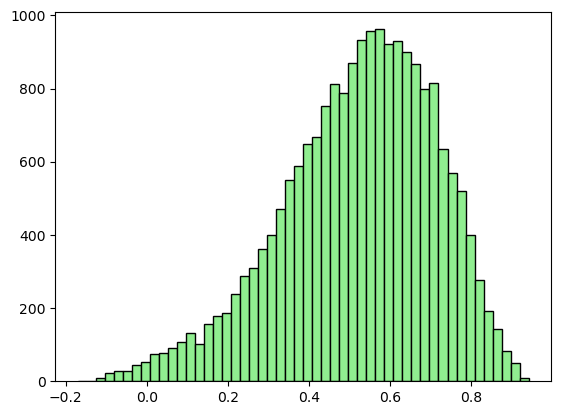

In [40]:
plt.hist(test_with_pred["predicted_score"], color='lightgreen', ec='black', bins=50)

# Evaluate using MRR@10

In [41]:
dict_qid_all_pid_prediction = {}

for qid, group in test_with_pred.groupby('query_id'):
    dict_qid_all_pid_prediction[qid] = group['passage_id'].values.tolist()

In [42]:

topn = 10
mrr = 0.0
qids = []
rrs = []

# iterate over all the qid (keys in the dictionary)
for qid in dict_qid_all_pid_prediction:

    rr = 0.0
    
    # iterate over all the element of topn pid [pid1, pid2, ... pid topn]
    for i, pid in enumerate(dict_qid_all_pid_prediction[qid][: topn + 1]):

        # check if the pid has relenvace > 0
        if qid in dict_of_dict_qid_pid_rel and pid in dict_of_dict_qid_pid_rel[qid] and dict_of_dict_qid_pid_rel[qid][pid] > 0:
        
            rr = 1 / (i+1)
        
            break
    qids.append(qid)
    rrs.append(rr)
    mrr += rr
mrr /= len(dict_qid_all_pid_prediction)
print("MRR@10: ", mrr)

MRR@10:  0.8844845238095242


# Evaluate using MAP@10

In [43]:
print(query_test.shape)
print(test_with_pred.shape)

result = query_test.merge(test_with_pred, how = "inner", on = ["query_id", "passage_id"])
print(result.shape)
display(result.head())

(20000, 9)
(20000, 3)
(20000, 10)


,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,0.687357
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,0.517978
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,0.630939
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,0.570832
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,0.594764


In [44]:
# Function for calculating average precision for a query
def average_precision(qid, topn = 10):
    
    # ========= for each query_id, do the following:
    #print(f"Started to work on query_id {qid}")
    # get passage_id (each query_id would have upto 10 passage_id)
    qresult = result.loc[result["query_id"] == qid, ["passage_id", "rel", "predicted_score"]]


    
    # sort rows so that passages with the highest similarity ranks as top 
    qresult.sort_values(by="predicted_score", ascending = False, inplace=True)

    # # Taking Top 10 documents for the evaluation
    ranking = qresult.head(topn)['rel'].values
    #display(qresult.head(topn))
    
    # # Calculating precision
    precision=[]
    for i in range(1,11):
      if ranking[i-1]:
        precision.append(np.sum(ranking[:i])/i)
    
    # If no relevant document in list then return 0
    if precision==[]:
      return 0
    #print(len(precision))
    #print(precision)
    avg_precision = np.mean(precision)
    #print("Avg precision: {}".format(avg_precision))
    return avg_precision#, len(precision), qresult.shape[0]

In [45]:
result["avg_precision"] = result.apply(lambda x: average_precision(x['query_id'])
                                    ,axis=1)

In [46]:
result.head()

,query_id,query,used,passage_id,rank,score,username,rel,query_cleaned,predicted_score,avg_precision
0,203324,him functions to the paper health record,Q0,msmarco_passage_49_115778700,1,13.2671,Anserini,1,him functions to the paper health record,0.687357,0.961735
1,203324,him functions to the paper health record,Q0,msmarco_passage_26_450017756,2,11.8537,Anserini,1,him functions to the paper health record,0.517978,0.961735
2,203324,him functions to the paper health record,Q0,msmarco_passage_19_202396335,3,11.2738,Anserini,1,him functions to the paper health record,0.630939,0.961735
3,203324,him functions to the paper health record,Q0,msmarco_passage_28_623516004,4,11.0361,Anserini,1,him functions to the paper health record,0.570832,0.961735
4,203324,him functions to the paper health record,Q0,msmarco_passage_02_47181174,5,10.9476,Anserini,1,him functions to the paper health record,0.594764,0.961735


In [47]:
print('Mean Average Precision=>', result["avg_precision"].mean())

Mean Average Precision=> 0.8079617638259008


In [48]:
result.to_csv("./output/test_prediction_biencoder_norefit_avg_precision_MiniLM-L6-v2_2024-04-21.csv"
                                       , index = False)
